In [1]:
def make_sig_mtrx(fly,parallel = True):
    def get_line_database():
        #print line_name
        import cPickle
        f = open('../mn_expression_matrix_plot/line_database.cpkl','rb')
        line_database = cPickle.load(f)
        f.close()
        return line_database

    def parse_GMR_genotype(genotype):
        """get the GMR and UAS keys in a given genotype"""
        print genotype
        gcamp_idx =  genotype.find('GCaMP6f')
        GFP_idx = genotype.find('GFP')
        gmr_idx = genotype.find('GMR')
        gmr_str = genotype[gmr_idx+3:gmr_idx+8]
        if gcamp_idx > 0:
            return {'uas':'GCaMP6f','gal4':gmr_str}
        elif GFP_idx > 0:
            return {'uas':'eGFP','gal4':gmr_str}

    def get_signal_dict(fly):
        """merge the signals from the nnls fits and the fly_record file into a single dictionary"""
        import h5py
        import cPickle
        import numpy as np
        fly_path = fly.fly_path
        muscle_data_file = fly_path+ 'nnls_fits_bk_sub_F.cpkl'
        #muscle_data_file = fly_path+'nnls_fits_no_bk_dF_F.cpkl'
        fly_record_file = fly_path+'fly_record.hdf5'
        signal_dict = dict()
        fi = open(muscle_data_file,'rb')
        muscle_data = cPickle.load(fi)
        fi.close()
        for mu,sig in zip(muscle_data['muscles'],muscle_data['fits']):
            signal_dict[mu] = sig
        hf = h5py.File(fly_record_file,'r')
        exp_record = hf['experiments'].values()[0]
        for key in exp_record['tiff_data']['axon_framebase'].keys():
            signal_dict[key] = np.array(exp_record['tiff_data']['axon_framebase'][key])
        hf.close()
        return signal_dict
    
    try:
        import group_data as gd
        from scipy.interpolate import griddata
        import numpy as np
        import flylib

        line_profile = get_line_database()[parse_GMR_genotype(flylist[0].get_genotype())['gal4']]
        muscles_in_line = [key for key,item in line_profile.items() if (item  > 0)]
        muscles_in_line = [m for m in muscles_in_line if not(m == 'ps')]
        #print muscles_in_line

        sigs = get_signal_dict(fly)#fly_dict['sigs']
        fly_path = fly.fly_path#fly_dict['fly_path']
        trials = flylib.idx_by_thresh(sigs['StimCond'],-0.0)
        exp_name = fly.list_expmnts()[0]
        signal_mtrxs = dict()

        xi = np.linspace(0,23,1150)

        ##########
        ##### Motion stim
        ##########
        for key in sigs:
            signal_mtrxs[key] = list()

        signal_mtrxs['trial_cond'] = list()
        signal_mtrxs['fly_num'] = list()
        signal_mtrxs['exp_names'] = list()
        signal_mtrxs['trial_time'] = list()

        for trial in trials:
            try:
                cond = gd.decode_map[exp_name](sigs['StimCond'][trial])
                t0 = sigs['times'][trial][0]
                tn = sigs['times'][trial][-1]

                signal_mtrxs['trial_time'].append(np.array([t0,tn]))

                times = sigs['times'][trial] - sigs['times'][trial[0]]

                #signal_mtrxs['fly_num'].append(fly.fly_num)
                signal_mtrxs['trial_cond'].append(cond)
                signal_mtrxs['fly_num'].append(fly.fly_num)
                signal_mtrxs['exp_names'].append(exp_name)
                for skey in sigs.keys():#['wb_period','wb_frequency','strobe_time','Ph0','Ph1','Ph2','Ph3','StimCond']:
                    #print trial
                    resamp = griddata(times,np.array(sigs[skey])[trial],xi,method = 'linear')
                    signal_mtrxs[skey].append(resamp)
            except ValueError:
                print 'ValueError'
        ##########
        ##### Stripe fixation
        ##########
        stfix = flylib.idx_by_thresh(sigs['StimCond']*-1,0.5)[0]
        t0 = sigs['times'][stfix][0]
        tn = sigs['times'][stfix][-1]
        while ((t0+23.5) < tn):
            trial = np.squeeze(np.where((sigs['times'] > t0) & (sigs['times'] < (t0+23))))
            try:
                cond = 'stripe_fix'
                times = sigs['times'][trial] - sigs['times'][trial[0]]
                #signal_mtrxs['fly_num'].append(fly.fly_num)
                signal_mtrxs['trial_cond'].append(cond)
                signal_mtrxs['fly_num'].append(fly.fly_num)
                signal_mtrxs['exp_names'].append(exp_name)
                signal_mtrxs['trial_time'].append(np.array([t0,t0+23]))
                for skey in sigs.keys():
                    resamp = griddata(times,np.array(sigs[skey])[trial],xi,method = 'linear')
                    signal_mtrxs[skey].append(resamp)
                t0 += 23
            except ValueError:
                print 'ValueError'
        ##########
        ##### Flight starts
        ##########
        fsig = np.array(sigs['wb_frequency'])
        #fsig = hstack((fsig,[0,0]))
        epoch_times = [(sigs['times'][ep[0]]-5,
                        sigs['times'][ep[0]]+18) for ep in flylib.idx_by_thresh(fsig,50) if np.shape(ep)[0]>500]

        trials = [np.squeeze(np.where((sigs['times'] > ep[0]) & (sigs['times'] < ep[1]))) for ep in epoch_times]
        ### need to find a better way to extract the #frames
        #print sigs
        trials = [ep for ep in trials if (ep[-1] < len(sigs[muscles_in_line[0]]))]
        xi = np.linspace(0,23,1150)
        for trial in trials:
            try:
                cond = 'flight_starts'
                t0 = sigs['times'][trial][0]
                tn = sigs['times'][trial][-1]

                times = sigs['times'][trial] - sigs['times'][trial[0]]
                signal_mtrxs['trial_time'].append(np.array([t0,tn]))

                signal_mtrxs['trial_cond'].append(cond)
                signal_mtrxs['fly_num'].append(fly.fly_num)
                signal_mtrxs['exp_names'].append(exp_name)
                for skey in sigs.keys():
                    resamp = griddata(times,np.array(sigs[skey])[trial],xi,method = 'linear')
                    signal_mtrxs[skey].append(resamp)
            except ValueError:
                print 'ValueError'

        ##########
        ##### Flight stops
        ##########        
        epoch_times = [(sigs['times'][ep[-1]]-5,
                        sigs['times'][ep[-1]]+18) for ep in flylib.idx_by_thresh(fsig,50) if np.shape(ep)[0]>500]

        trials = [np.squeeze(np.where((sigs['times'] > ep[0]) & (sigs['times'] < ep[1]))) for ep in epoch_times]
        trials = [ep for ep in trials if (ep[-1] < len(sigs[muscles_in_line[0]]))]
        xi = np.linspace(0,23,1150)
        for trial in trials:
            try:
                cond = 'flight_stops'
                t0 = sigs['times'][trial][0]
                tn = sigs['times'][trial][-1]
                #print trial
                times = sigs['times'][trial] - sigs['times'][trial[0]]
                signal_mtrxs['trial_time'].append(np.array([t0,tn]))

                signal_mtrxs['trial_cond'].append(cond)
                signal_mtrxs['fly_num'].append(fly.fly_num)
                signal_mtrxs['exp_names'].append(exp_name)
                for skey in sigs.keys():
                    resamp = griddata(times,np.array(sigs[skey])[trial],xi,method = 'linear')
                    signal_mtrxs[skey].append(resamp)
            except ValueError:
                print 'ValueError' 

        for key in signal_mtrxs:
            signal_mtrxs[key] = np.array(signal_mtrxs[key])

        if parallel:
            import cPickle
            #f = open(fly.fly_path + 'nnls_fits_no_bk_dF_F_sig_mtrx.cpkl','wb')
            f = open(fly.fly_path + 'nnls_fits_bk_sub_F_sig_mtrx.cpkl','wb')
            cPickle.dump(signal_mtrxs,f)
            f.close()
        else:
            return signal_mtrxs
    except Exception, err: # catch *all* exceptions
        return err

In [12]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
import pylab as plb
plb.rcParams['pdf.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


In [1]:
import group_data as gd

In [17]:
fly = gd.GMR40D04_ca_swarm.flies[0]

In [18]:
fly.open_fly_record()

In [19]:
expmnt = fly.get_expmnt(fly.list_expmnts()[0])

In [20]:
fdata = fly.get_pkl_data('trial_data.cpkl')

In [22]:
len(fdata)

72

(array([  3.02805510e+07,   5.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   6.00000000e+00,   5.00000000e+00,
          5.10603030e+07,   3.00000000e+00,   3.00305000e+05,
          1.00000000e+00,   0.00000000e+00,   3.00243000e+05,
          2.00000000e+00,   3.00195000e+05,   1.00000000e+00,
          2.00000000e+00,   3.00418000e+05,   0.00000000e+00,
          3.00355000e+05,   0.00000000e+00,   1.00000000e+00,
          3.00256000e+05,   1.00000000e+00,   3.00309000e+05,
          0.00000000e+00,   1.00000000e+00,   3.00200000e+05,
          1.00000000e+00,   3.00593000e+05,   1.00000000e+00,
          0.00000000e+00,   3.00264000e+05,   0.00000000e+00,
          2.88143000e+05,   1.24210000e+04,   1.00000000e+00,
          3.00199000e+05,   1.00000000e+00,   0.00000000e+00,
          3.00702000e+05,   0.00000000e+00,   3.00407000e+05,
          1.00000000e+00,   1.00000000e+00,   3.00249000e+05,
        

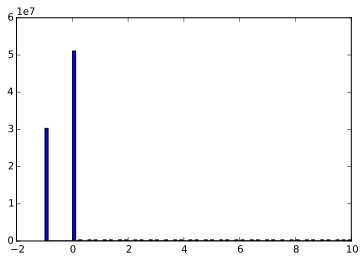

In [3]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [5]:
#file_name = 'nnls_fits_no_bk_dF_F_sig_mtrx.cpkl',
#flylist = [gd.GMR22H05_pr_swarm.flies+gd.GMR22H05_prc_swarm.flies+ gd.GMR22H05_swarm.flies][0]
#flylist = gd.get_update_list(swarms = [gd.GMR22H05_pr_swarm,gd.GMR22H05_prc_swarm, gd.GMR22H05_swarm],
#                             file_name = 'nnls_fits_bk_sub_F_sig_mtrx.cpkl',
#                             replace = True)
flylist = gd.swarms['GMR40D04_pr'].flies[-2:]

In [7]:
[fl.fly_num for fl in flylist]

[602, 603]

In [8]:
#parallize accross flies
from IPython.parallel import Client
clients = Client() 
clients.block = True
print clients.ids
v = clients[:]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [9]:
v.map(make_sig_mtrx,flylist)

[IOError(2, 'No such file or directory'),
 IOError(2, 'No such file or directory')]

In [10]:
[make_sig_mtrx(fl) for fl in flylist]

+;P{20XUAS-IVS-GCaMP6f}attP40/+;P{y[+t7.7] w[+mC]=GMR40D04-GAL4}attP2/+
+;P{20XUAS-IVS-GCaMP6f}attP40/+;P{y[+t7.7] w[+mC]=GMR40D04-GAL4}attP2/+


[None, None]

In [11]:
import os
os.listdir(flylist[0].fly_path)

['nnls_fits_bk_sub_F_sig_mtrx.cpkl',
 'epoch_data.cpkl',
 'genotype.txt',
 'basis_fits.cpkl',
 'nnls_fits_bk_sub_F.cpkl',
 'fly_record.hdf5']